In [1]:
from math import sqrt
from operator import sub
from matplotlib import pyplot as plt
from random import random, randint

In [2]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank) for j in range(rank)] for i in range(rank)]

In [3]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int, strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-system, 1 - ant-density, 2 - ant-quantity
        """
        
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    def solve(self, graph: Graph):        
        best_cost = float('inf')
        best_solution = []
        
        for gen in range(self.generations):
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                for i in range(graph.rank - 1):
                    ant._select_next()
                    
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                ant.tabu.append(ant.tabu[0])
                
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                
                # update pheromone
                ant._update_pheromone_delta()
                
            self._update_pheromone(graph, ants)
            # print('generation #{}, best cost: {}, path: {}'.format(gen, best_cost, best_solution))
        return best_solution, best_cost

In [4]:
class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in range(graph.rank)]  # heuristic information
        start = randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][i] ** self.colony.beta
        
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        #rand = random()
        max_prob = 0
        for i, probability in enumerate(probabilities):
#             rand -= probability
#             if rand <= 0:
#                 selected = i
#                 break
            if probability > max_prob :
                max_prob = probability
                selected = i
            
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        
        for _ in range(1, len(self.tabu)): # len(self.tabu) == 32
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            
            if self.colony.update_strategy == 1:  # ant-density system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-quantity system
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [22]:
def plot(points, path: list):
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    y = list(map(sub, [max(y) for i in range(len(points))], y))
    
    plt.plot(x, y, 'co', figure=plt.figure(figsize=(12, 8))) # co == 'cyan circle marker' # figsize(width/horizontally, height/vertically)
    for a in range(1, len(path)):
        i = path[a - 1]
        j = path[a]
        plt.arrow(x=x[i], y=y[i], dx=x[j] - x[i], dy=y[j] - y[i], # dx, dy == length of arrow along x, y direction
            color='r' if a < len(path)-1 else 'b',
            ls="-" if a < len(path)-1 else ":", # ls == linestyle
            length_includes_head=True) # head is counted in calculating the length
    
#     plt.xlim(0, max(x) * 1.1)
#     plt.ylim(0, max(y) * 1.1)
    plt.show()

In [6]:
def distance(city1: dict, city2: dict):
    return sqrt((city1['x'] - city2['x']) ** 2 + (city1['y'] - city2['y']) ** 2)

In [7]:
def main():
    cities, points, cost_matrix = [], [], []
    
    with open('./data/chn31.txt') as f:
        for line in f.readlines():
            city = line.split(' ')
            cities.append(dict(index=int(city[0]), x=int(city[1]), y=int(city[2])))
            points.append((int(city[1]), int(city[2])))

#     print(cities)
#     print(points)

    rank = len(cities)
    for i in range(rank):
        row = []
        for j in range(rank):
            row.append(distance(cities[i], cities[j]))
        cost_matrix.append(row)
#     print(cost_matrix)

    aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 2)
    graph = Graph(cost_matrix, rank)
    path, cost = aco.solve(graph)
    print('cost: {}, path: {}'.format(cost, path))
    plot(points, path)

cost: 17097.666568773857, path: [15, 3, 1, 4, 5, 6, 12, 11, 13, 10, 22, 24, 19, 23, 18, 16, 17, 2, 20, 21, 25, 27, 26, 29, 30, 28, 0, 14, 7, 8, 9, 15]


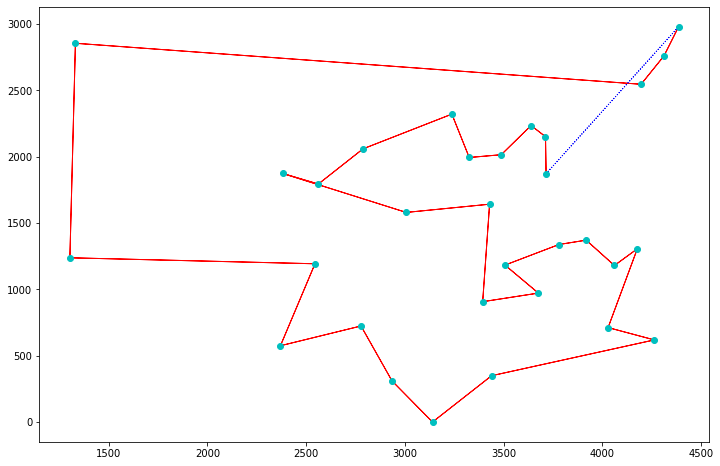

In [23]:
main()